In [79]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras import optimizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import scipy
import keras
import sys

In [103]:
#get arguments 1=ecal, 2=hcal, 3=muons
#if(len(sys.argv) < 2): print("need to specify which part of detector to train")
#else: det = int(sys.argv[1])
det = 3

#set epochs, batch size
num_epochs = 50
batches = 16

#set directories
workDir = "/Users/michaelcarrigan/Desktop/DisTracks/autoencoder/"
saveDir = workDir
dataDir = "/Users/michaelcarrigan/Desktop/DisTracks/data/"

#load data
data_e = np.load(dataDir+ "e_DYJets50_norm_40x40.npy")
data_bkg = np.load(dataDir + "bkg_DYJets50_norm_40x40.npy")
data = data_e
data = data[:, :, :, [0,2,3]]
data_bkg = data_bkg[:, :, :, [0,2,3]]
data_bkg = np.reshape(data_bkg, (-1, 40, 40, 3))
classes = np.array([np.ones(len(data_e)), np.ones(len(data_e)), np.ones(len(data_e))])
classes = np.reshape(classes, (len(data_e), 3))

#shuffle data
indicies = np.arange(data.shape[0])
np.random.shuffle(indicies)
data = data[indicies]
print(data.shape[0], "Number of samples")
print(np.shape(data))
print(np.shape(classes))

x_train, x_val, y_train, y_val = train_test_split(data, classes, test_size=0.15, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state=0)

print("Training Samples", x_train.shape[0])
print("Validation Samples", x_val.shape[0])
print("Test Samples", x_test.shape[0])

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)
y_val = keras.utils.to_categorical(y_val, 2)

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_val = x_val.astype('float32')

x_train = np.reshape(x_train, (-1, 40, 40, 3))
x_val = np.reshape(x_val, (-1, 40, 40, 3))
x_test = np.reshape(x_test, (-1, 40, 40, 3))

print(x_train.shape)
print(x_train.shape[0])

(7935, 'Number of samples')
(7935, 40, 40, 3)
(7935, 3)
('Training Samples', 6744)
('Validation Samples', 595)
('Test Samples', 596)
(6744, 40, 40, 3)
6744


(6744, 40, 40, 3)
5638
2487
5984
5708
1698


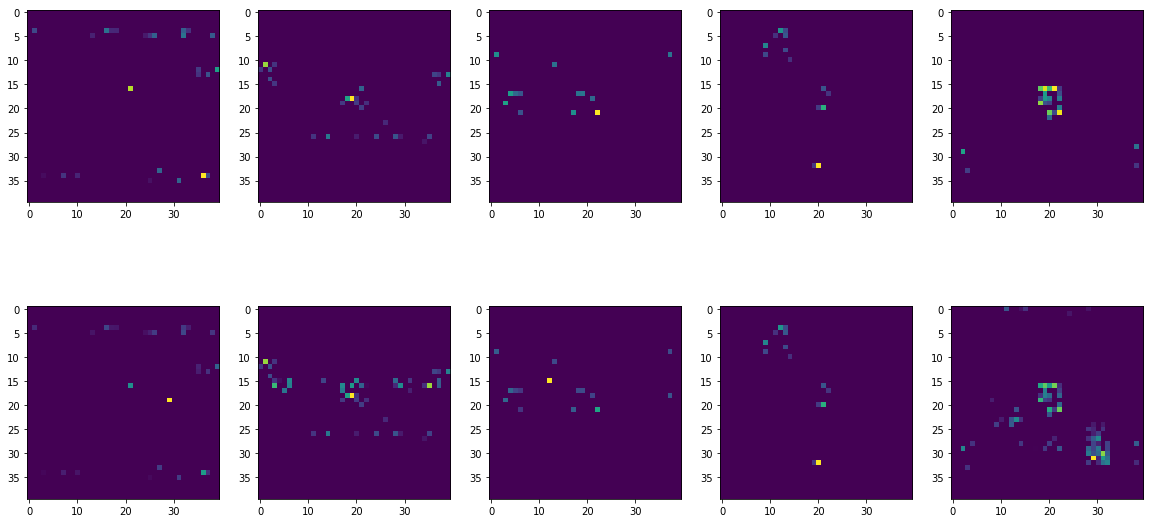

In [106]:
def noisyData(data_e, data_bkg):
    evts = len(data_e)
    noise = np.random.randint(0, len(data_bkg), evts)
    data_bkg = data_bkg[noise]
    #print(len(data_bkg))
    data_noise = np.copy(data_e)
    for i in range(len(data_e)):
        
        index = np.random.randint(0, len(data_bkg))
        norm_bkgE = np.linalg.norm(data_bkg[i, :, :, 0])
        norm_bkgH = np.linalg.norm(data_bkg[i, :, :, 1])
        norm_bkgM = np.linalg.norm(data_bkg[i, :, :, 2])
        if(norm_bkgE != 0): 
            norm_E = np.linalg.norm(data_e[i, :, :, 0])
            data_bkg[i, :, :, 0] = data_bkg[i, :, :, 0] * norm_E/norm_bkgE
        if(norm_bkgH != 0):
            norm_H = np.linalg.norm(data_e[i, :, :, 1])
            data_bkg[i, :, :, 1] = data_bkg[i, :, :, 1] * norm_H/norm_bkgH
        if(norm_bkgM != 0):
            norm_M  = np.linalg.norm(data_e[i, :, :, 2])
            data_bkg[i, :, :, 2] = data_bkg[i, :, :, 2] * norm_M/norm_bkgM
        data_noise[i, :, :, 0] = np.add(data_e[i, :, :, 0], data_bkg[i, :, :, 0])
        data_noise[i, :, :, 1] = np.add(data_e[i, :, :, 1], data_bkg[i, :, :, 1])
        data_noise[i, :, :, 2] = np.add(data_e[i, :, :, 2], data_bkg[i, :, :, 2])
    #norm_noise = np.linalg.norm(data_noise)
    #data_noise = data_noise * (norm_e/norm_noise)
    return data_noise

noisyTrain = noisyData(x_train, data_bkg)
noisyVal = noisyData(x_val, data_bkg)
#noisyTest = noisyData(x_test, data_bkg)

print(noisyTrain.shape)

layer=1
fig1, plot1 = plt.subplots(2,5, figsize=(20,10))
for i in range(5):
    rand = np.random.randint(0, len(noisyTrain))
    print(rand)
    plot1[0, i].imshow(x_train[rand, :, :, layer])
    plot1[1, i].imshow(noisyTrain[rand, :, :, layer])


In [107]:
img = Input(shape = (40,40,3))
ae = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(img)
#ae = MaxPooling2D((2,2), padding = 'same')(ae)
#encoded = Conv2D(32, (3,3), strides = (2,2), activation = 'relu', padding = 'same')(ae)
#ae = Conv2D(32, (3,3), activation = 'relu', padding = "same")(ae)
encoded = MaxPooling2D((2,2), padding = 'same')(ae)
#encoded = Conv2D(16, (3,3), strides = (2,2), activation = 'relu', padding = 'same')(ae)

ae = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
#ae = Conv2DTranspose(32, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(ae)
ae = UpSampling2D((2,2))(ae)
#ae = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(ae)
#ae = UpSampling2D((2,2))(ae)
#ae = Conv2DTranspose(128, (3,3), strides = (2,2), activation = 'relu', padding = 'same')(ae)
decoded = Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')(ae)


In [108]:
autoencoder = Model(img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(noisyTrain, x_train, epochs = num_epochs, batch_size = batches, shuffle=True, validation_data = (noisyVal, x_val))

Train on 6744 samples, validate on 595 samples
Epoch 1/50
6744/6744 [==============================] - 32s 5ms/step - loss: 0.0396 - val_loss: 0.0177
Epoch 2/50
6744/6744 [==============================] - 33s 5ms/step - loss: 0.0159 - val_loss: 0.0141
Epoch 3/50
6744/6744 [==============================] - 28s 4ms/step - loss: 0.0134 - val_loss: 0.0127
Epoch 4/50
6744/6744 [==============================] - 30s 4ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 5/50
6744/6744 [==============================] - 27s 4ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 6/50
6744/6744 [==============================] - 30s 4ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 7/50
6744/6744 [==============================] - 37s 6ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 8/50
6744/6744 [==============================] - 35s 5ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 9/50
6744/6744 [==============================] - 32s 5ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 10/50
6744/6744 [===

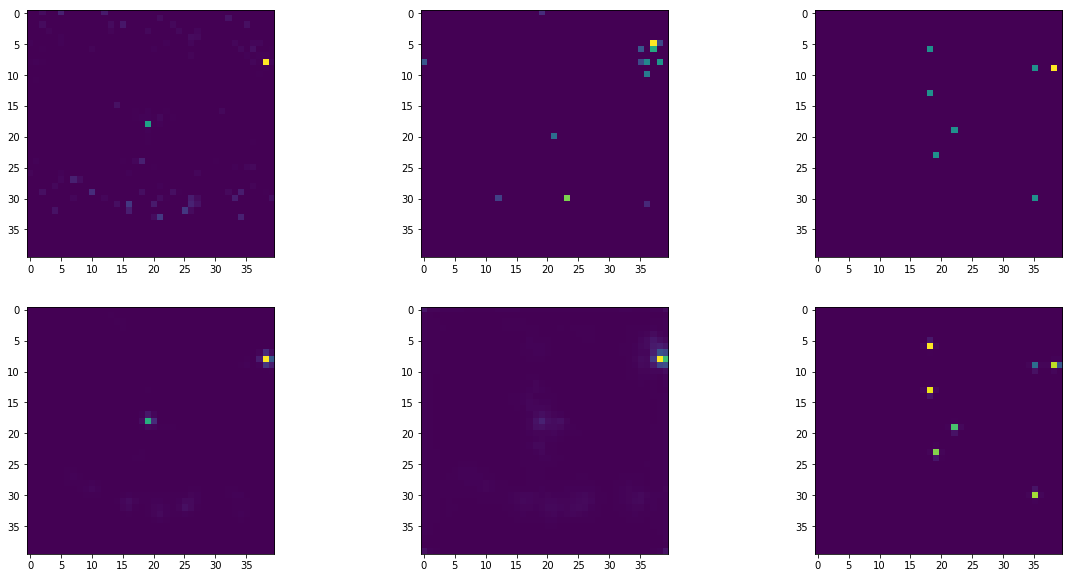

In [114]:
decoded_img = autoencoder.predict(x_test)
fig, h = plt.subplots(2,3, figsize=(20,10))
index = np.random.randint(len(x_test[0]))
for i in range(3):
    this_orig = x_test[index, :, :, i]
    this_clean = decoded_img[index, :, :, i]
    h[0, i].imshow(this_orig)
    h[1, i].imshow(this_clean)
    